# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

## 3. Feature Engineering

**Observation:**

| # | Observation                                                                                                                                                                                            | Recommended Next Steps                                                                                                                                                                                                                                                          |
|:-:|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | The `Price` and `Area` variables are heavily right-skewed. This can negatively impact the performance of many machine learning models that assume a normal distribution.         | **Apply Log Transformation:** Use a function like `np.log1p` on these columns to normalize their distributions. After transforming, generate the boxplots again to confirm that the skewness has been reduced.  |
| 2 | Create dummy variables for discrete variables | In addition to creating dummy variables, you should try to reduce the size of the dataset. |
| 3 | Verify whether the variable Number of Bedrooms provides a better correlation with price as a continuous random variable or a discrete variable. | Evaluate binding in No of Bedrooms. To capture non-linear relationships: Sometimes, the relationship between a feature and price is not a straight line.
Hypothetical example: Perhaps 1- and 2-bedroom homes are cheap, 3- and 4-bedroom homes are very expensive, but 5-bedroom homes and above are cheaper again (because they are difficult to sell or are in worse areas). | 
| 4 | Divide the dataset and ensure price balancing | Create the training and test datasets and ensure that each set has the same proportion of samples in each quartile. |


### 3.1 Loading the dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import sys

sys.path.append('../../src/utils')


# Utilities
from housing_prices_column_definition import Column

sourceDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_cleanup.parquet'
targetDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_feauture_eng.parquet'

train_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_features.parquet'
train_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_labels.parquet'

test_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_features.parquet'
test_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_labels.parquet'

dataset = pd.read_parquet(sourceDataset)

## 3.2 Transformation of Skewed Numerical Features

**Problem:**
The numerical features Price and Area have highly right-skewed distributions, as observed in their descriptive statistics (the mean is significantly greater than the median). This can negatively affect the performance of models that are sensitive to the scale and distribution of the data, such as linear models.

**Justification:**

A logarithmic transformation (np.log1p) compresses the range of the higher values, reducing the impact of outliers and making the distribution more symmetrical (similar to a normal distribution). This helps to stabilize the variance and meet the assumptions of many Machine Learning algorithms, which generally leads to better performance and a more robust model.

**Action:**

- Apply the np.log1p transformation to the Price and Area columns to normalize their distribution.
- It is not advisable to apply a logarithmic transformation to the No. of Bedrooms column. Unlike Price and Area, this variable is not continuous, but discrete, and has a very small and limited range of values (e.g., 1, 2, 3, 4, 5 bedrooms). Logarithmic transformation will not provide any benefits and will complicate the interpretation of the model.

**Verification:**

Before (left) and after (right) applying logarithm


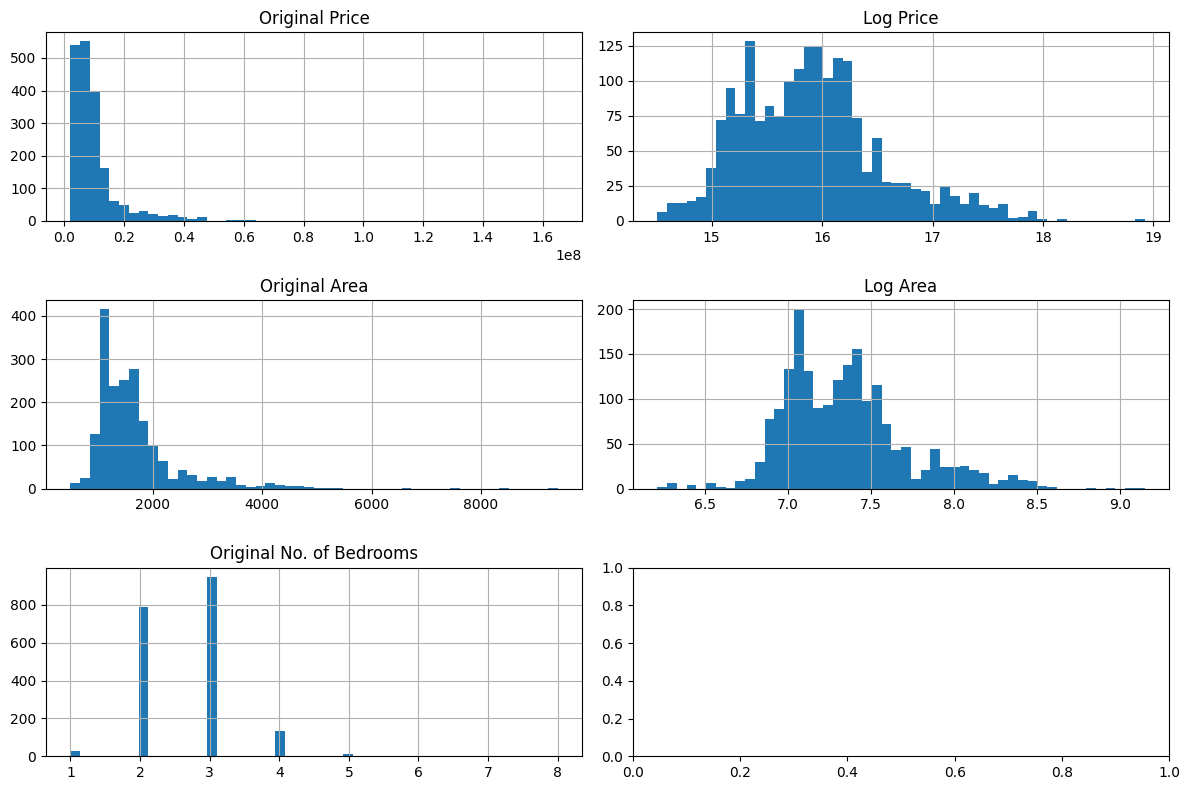

In [2]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

dataset[Column.PRICE.name].hist(ax=axes[0,0], bins=50).set_title('Original Price')
dataset[Column.AREA.name].hist(ax=axes[1,0], bins=50).set_title('Original Area')
dataset[Column.NO_OF_BEDROOMS.name].hist(ax=axes[2,0], bins=50).set_title('Original No. of Bedrooms')

dataset[Column.PRICE.name] = np.log1p(dataset[Column.PRICE.name])
dataset[Column.AREA.name] = np.log1p(dataset[Column.AREA.name])

dataset[Column.PRICE.name].hist(ax=axes[0,1], bins=50).set_title('Log Price')
dataset[Column.AREA.name].hist(ax=axes[1,1], bins=50).set_title('Log Area')

display(Markdown('**Verification:**'))
print("Before (left) and after (right) applying logarithm") 
plt.tight_layout()
plt.show()

dataset.to_parquet(targetDataset)

## 3.3 Grouping Infrequent Locations and Hot encoding

**Problem:**

Machine learning algorithms require numeric inputs. The Location column is categorical and has a very high number of unique values (high cardinality), which makes standard One-Hot Encoding impractical.

**Justification:**

Creating a separate column for each of the 239 locations would lead to the "curse of dimensionality," making the model unnecessarily complex and potentially prone to overfitting. A more effective strategy is to group infrequent locations into a single "Other" category. This approach reduces the number of dimensions while retaining the most statistically significant locations. We can then apply One-Hot Encoding to this simplified set of categories.

**Action:**

- Identify all locations that appear fewer times than a specified threshold (e.g., 10 times).
- Replace these infrequent location names with the string "Other".
- Apply pd.get_dummies to the modified Location column to create the final numeric features.
- Amenities columns do not need to be converted to one-hot encoding because they are already in a binary or Boolean format that is understandable by machine learning algorithms.
-  The variable No of Bedrooms is a discrete numeric variable, not nominal categorical, which means its values have an inherent and significant order of magnitude. In practice, applying one-hot encoding to this variable is a mistake.

In [3]:
location_counts = dataset[Column.LOCATION.name].value_counts()
threshold = 10

unique_locations_before = dataset[Column.LOCATION.name].nunique()
infrequent_locations = location_counts[location_counts < threshold].index
locations_modified = dataset[Column.LOCATION.name].replace(infrequent_locations, 'Other')
uniqueLocationAfter = locations_modified.nunique()

location_dummies = pd.get_dummies(locations_modified, prefix=Column.LOCATION.name, drop_first=True)

dataset_with_dummies = pd.concat([dataset.drop(columns=Column.LOCATION.name), location_dummies], axis=1)

display(Markdown('**Verification:**'))
print(f"Number of unique locations before clustering {unique_locations_before}") 
print(f"Number of unique locations after clustering: {uniqueLocationAfter}")


dataset_with_dummies.to_parquet(targetDataset)

**Verification:**

Number of unique locations before clustering 239
Number of unique locations after clustering: 50


## 3.4 Evaluate binding in No of Bedrooms


**Problem:**

We must ensure that the No of Bedrooms column, which is a discrete numeric variable, correlates with our label (Price). If it does not, we may be able to obtain better results by applying binding.

**Justification:**

If we detect that No of Bedrooms has no correlation with Price, we are more likely to obtain better predictions if we apply binding to the column.

**Action:**

Should not use binning on the No. of Bedrooms feature because its relationship with Price is monotonic and largely linear. This means that as the number of bedrooms increases, the price predictably tends to increase as well.

### 1. Analysis with the Original Variable

--- Original Correlation (Price vs. No of Bedrooms) ---
                    Price  No. of Bedrooms
Price            1.000000         0.711704
No. of Bedrooms  0.711704         1.000000

Distribution of original values:
No. of Bedrooms
1     30
2    788
3    948
4    131
5     13
6      2
8      2
Name: count, dtype: int64



### 2. Análisis con la Variable Agrupada (Binning)

New categories created (Bins):
BEDROOMS_BINNED
1      30
2     788
3     948
4     131
5      13
6       2
7       0
8+      2
Name: count, dtype: int64

--- Correlation with Binning (Price vs. Bedrooms_Binned_Encoded) ---
                    Price  No. of Bedrooms
Price            1.000000         0.447465
No. of Bedrooms  0.447465         1.000000


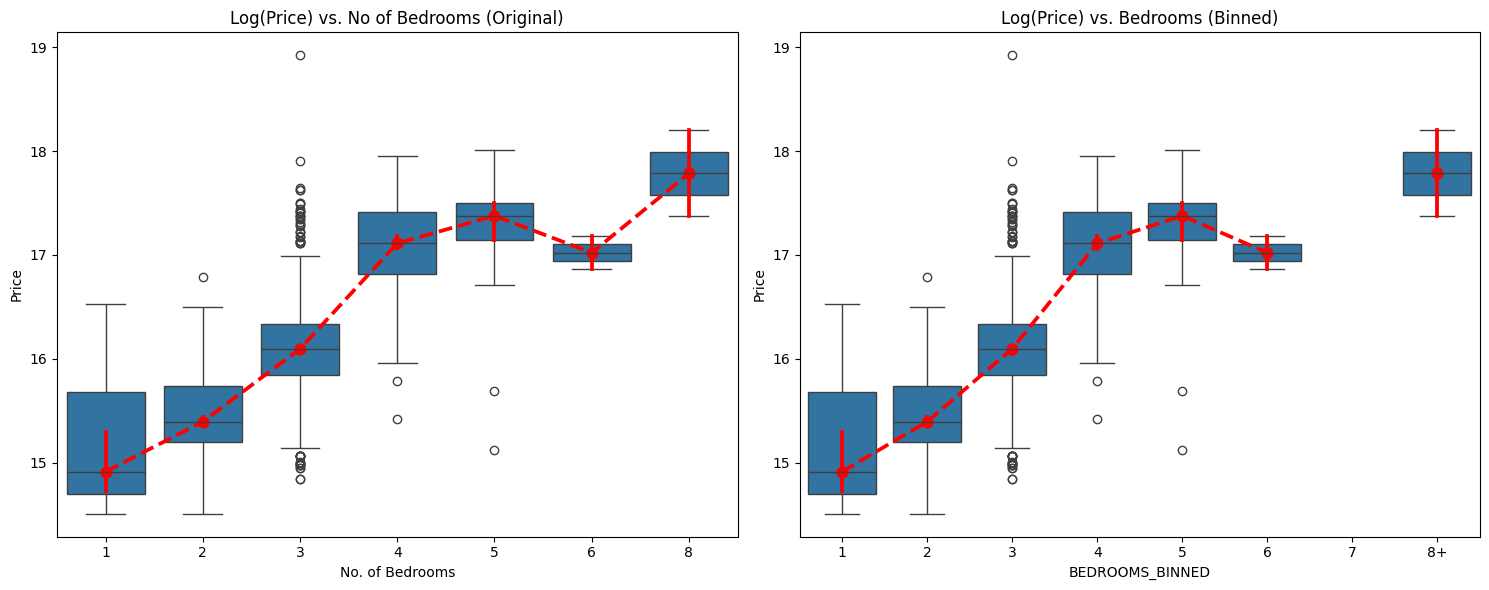

In [4]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np  # <-- AÑADIDO: Necesario para el estimador de mediana

# Usamos el dataframe que ya tiene las dummies de ubicación
# Hacemos una copia para no alterar el flujo de tu notebook
data_comparison = dataset_with_dummies.copy()

# --- 1. Análisis de la Variable Original ---

display(Markdown("### 1. Analysis with the Original Variable"))

# Calcular la correlación de Pearson original
corr_original = data_comparison[[Column.PRICE.name, Column.NO_OF_BEDROOMS.name]].corr()

print("--- Original Correlation (Price vs. No of Bedrooms) ---")
print(corr_original)
print("\nDistribution of original values:")
print(data_comparison[Column.NO_OF_BEDROOMS.name].value_counts().sort_index())

# Visualización (Boxplot)
plt.figure(figsize=(15, 6)) # <-- Hice el gráfico un poco más ancho
ax1 = plt.subplot(1, 2, 1) # <-- Capturamos el eje (ax1)
sns.boxplot(data=data_comparison, x=Column.NO_OF_BEDROOMS.name, y=Column.PRICE.name, ax=ax1)

# Dibuja una línea conectando la MEDIANA de cada categoría
sns.pointplot(data=data_comparison, x=Column.NO_OF_BEDROOMS.name, y=Column.PRICE.name, 
              ax=ax1, 
              estimator=np.median,  # <-- Usa la mediana (no la media)
              color='red', 
              markers='o', 
              linestyles='--')
# ---------------------

plt.title('Log(Price) vs. No of Bedrooms (Original)')


# --- 2. Creación y Análisis de la Variable Agrupada (Binned) ---

display(Markdown("\n### 2. Análisis con la Variable Agrupada (Binning)"))

# Definimos los 'cortes' para agrupar (basado en tu imagen)
bins = [0, 1, 2, 3, 4, 5, 6, 7, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8+']

# Creamos la nueva columna agrupada
BEDROOMS_BINNED = 'BEDROOMS_BINNED'
data_comparison[BEDROOMS_BINNED] = pd.cut(data_comparison[Column.NO_OF_BEDROOMS.name],
                                         bins=bins,
                                         labels=labels,
                                         right=True) 

print("New categories created (Bins):")
print(data_comparison[BEDROOMS_BINNED].value_counts().sort_index())

# Para calcular la correlación, necesitamos convertir los bins (que son texto) a números
data_comparison['BEDROOMS_BINNED_ENCODED'] = pd.factorize(data_comparison[BEDROOMS_BINNED])[0]

# Calculamos la correlación de la variable agrupada y codificada
corr_binned = data_comparison[[Column.PRICE.name, 'BEDROOMS_BINNED_ENCODED']].corr()

print("\n--- Correlation with Binning (Price vs. Bedrooms_Binned_Encoded) ---")
print(corr_binned.rename(columns={'BEDROOMS_BINNED_ENCODED': Column.NO_OF_BEDROOMS.name},
                         index={'BEDROOMS_BINNED_ENCODED': Column.NO_OF_BEDROOMS.name}))

# Visualización
ax2 = plt.subplot(1, 2, 2) # <-- Capturamos el eje (ax2)
sns.boxplot(data=data_comparison, x=BEDROOMS_BINNED, y=Column.PRICE.name, ax=ax2)

# --- LÍNEA AÑADIDA ---
# Dibuja una línea conectando la MEDIANA de cada categoría
sns.pointplot(data=data_comparison, x=BEDROOMS_BINNED, y=Column.PRICE.name, 
              ax=ax2, 
              estimator=np.median,  # <-- Usa la mediana
              color='red', 
              markers='o', 
              linestyles='--')
# ---------------------

plt.title('Log(Price) vs. Bedrooms (Binned)')
plt.tight_layout()
plt.show()

### 3.5 Split data

**Problem:**

A simple random split of the dataset into training, validation, and test sets can create imbalanced subsets. This means one set might accidentally contain a disproportionate number of expensive or cheap houses compared to the others. A model trained on such a skewed dataset will develop a bias, leading to poor generalization and inaccurate performance metrics when evaluated on the other sets.

**Justification:**

For a model's evaluation to be reliable, the training, validation, and test sets must be representative samples of the overall data distribution. By ensuring that the statistical properties of the target variable (in this case, the distribution of house prices) are consistent across all splits, we guarantee that the model learns the true underlying patterns from the data. This results in a more robust model that performs predictably on new, unseen data, and our evaluation metrics will reflect its true capabilities.

**Action:**

We will use stratified sampling to perform the data split. This technique divides the data into homogeneous subgroups (strata) based on the price distribution before sampling. By drawing proportional samples from each stratum to build the training, validation, and test sets, we ensure that each set is a faithful and balanced representation of the original dataset's price distribution.


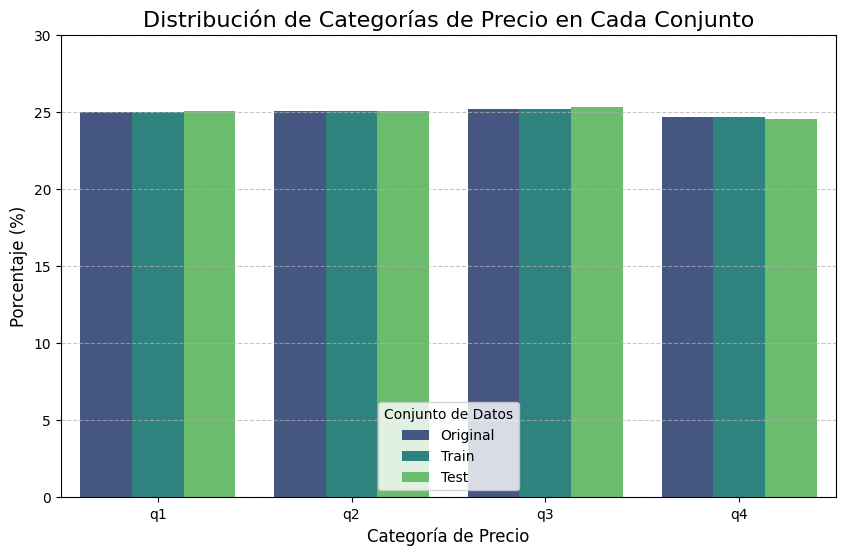

In [5]:

PRICE_CAT = 'price_cat'

processedDataset = pd.read_parquet(targetDataset)
processedDataset[PRICE_CAT] = pd.qcut(processedDataset[Column.PRICE.name], q=4, labels=['q1', 'q2', 'q3', 'q4'])

features = processedDataset.drop(Column.PRICE.name, axis=1)
labels = processedDataset[Column.PRICE.name]

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, stratify=features[PRICE_CAT], random_state=42
)

# # give the proportion of q1, q2, q3, q4 for each set
original_dist = features[PRICE_CAT].value_counts(normalize=True).sort_index()
train_dist = features_train[PRICE_CAT].value_counts(normalize=True).sort_index()
test_dist = features_test[PRICE_CAT].value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    "Original": original_dist * 100,
    "Train": train_dist * 100,
    "Test": test_dist * 100
})


plot_data = comparison_df.reset_index().melt(
    id_vars=PRICE_CAT,
    var_name='Set',
    value_name='Percentage'
)


plot_data.rename(columns={PRICE_CAT: 'Price Category'}, inplace=True)

# Creamos el gráfico de barras (sin cambios)
plt.figure(figsize=(10, 6))
sns.barplot(x='Price Category', y='Percentage', hue='Set', data=plot_data, palette='viridis')

plt.title('Distribución de Categorías de Precio en Cada Conjunto', fontsize=16)
plt.xlabel('Categoría de Precio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.ylim(0, 30)
plt.legend(title='Conjunto de Datos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig('stratified_split_verification.png')
plt.show()


# Limpieza final de la columna 'price_cat'
for set_ in (features_train, features_test):
    set_.drop(PRICE_CAT, axis=1, inplace=True)


features_train.to_parquet(train_features_path)
labels_train.to_frame().to_parquet(train_labels_path)

features_test.to_parquet(test_features_path)
labels_test.to_frame().to_parquet(test_labels_path)
